In [1]:
# import the required libraries

import torch
from torch import nn

torch.__version__

'2.1.2+cu118'

In [2]:
# setup the device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# get and download the dataset
# we're going to use subsets of Food101 dataset

import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} directory already exists ...")
else:
    print(f"{image_path} doesn't exist, creating one ...")
    image_path.mkdir(parents=True, exist_ok=True)


# download the dataset
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading the dataset ...")
    f.write(request.content)


# unzip the downloaded datadet
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unziping the dataset ...")
    zip_ref.extractall(image_path)

data\pizza_steak_sushi directory already exists ...
Unziping the dataset ...


In [4]:
# data preparation and exploration
import os

def walk_through_dir(dir_path):
    """Walks through dir_path returing it's content

    Args:
        dir_path (str): _description_
    """
    
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

In [5]:
image_path

WindowsPath('data/pizza_steak_sushi')

In [6]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\pizza_steak_sushi'
There are 3 directories and 0 images in 'data\pizza_steak_sushi\test'
There are 0 directories and 25 images in 'data\pizza_steak_sushi\test\pizza'
There are 0 directories and 19 images in 'data\pizza_steak_sushi\test\steak'
There are 0 directories and 31 images in 'data\pizza_steak_sushi\test\sushi'
There are 3 directories and 0 images in 'data\pizza_steak_sushi\train'
There are 0 directories and 78 images in 'data\pizza_steak_sushi\train\pizza'
There are 0 directories and 75 images in 'data\pizza_steak_sushi\train\steak'
There are 0 directories and 72 images in 'data\pizza_steak_sushi\train\sushi'


In [7]:
# setup the train and test path
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

Path: data\pizza_steak_sushi\train\pizza\1633289.jpg
Image class: pizza
Image height: 384
Image width: 512


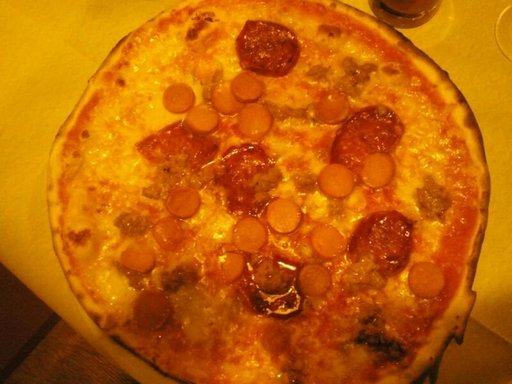

In [8]:
# visualizing an image
import random
from PIL import Image

# get all the image path
image_path_list = list(image_path.glob("*/*/*.jpg"))

# select a random image path
random_image_path = random.choice(image_path_list)
print(f"Path: {random_image_path}")

# get the image class
image_class = random_image_path.parent.stem
print(f"Image class: {image_class}")

# open the image
img = Image.open(random_image_path)
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

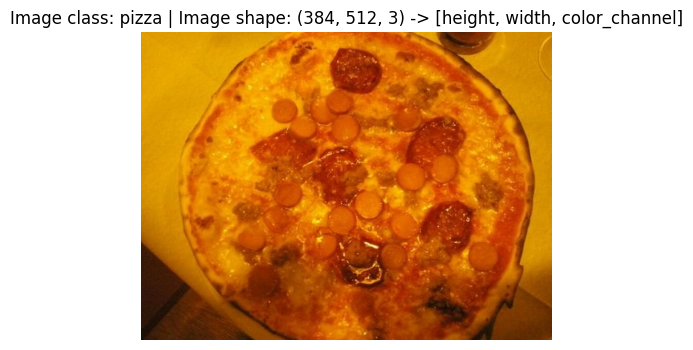

In [9]:
# try to visualize the image using matplotlib
import numpy as np
import matplotlib.pyplot as plt

# convert the image to numpy array
image_array = np.asarray(img)

# let's visualize the image
plt.figure(figsize=(6, 4))
plt.imshow(image_array)
plt.title(f"Image class: {image_class} | Image shape: {image_array.shape} -> [height, width, color_channel]")
plt.axis(False)
plt.show()

In [39]:
# image_array

#### Transforming data

In [10]:
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms

In [11]:
# write a transformation for image
data_transform = transforms.Compose([
    # resize the image to 64X64
    transforms.Resize(size=(64, 64)),
    
    # flip the image randomly on the horizontal axis
    transforms.RandomHorizontalFlip(p=0.5),
    
    # turn the image into torch.Tensor
    transforms.ToTensor()
])

In [12]:
data_transform(img)

tensor([[[0.8745, 0.8745, 0.8745,  ..., 0.8157, 0.8078, 0.8196],
         [0.8784, 0.8863, 0.8824,  ..., 0.8118, 0.8235, 0.8392],
         [0.8784, 0.8863, 0.8902,  ..., 0.8157, 0.8392, 0.7843],
         ...,
         [0.1255, 0.1373, 0.2157,  ..., 0.3922, 0.3882, 0.3725],
         [0.1137, 0.1843, 0.2471,  ..., 0.3804, 0.3843, 0.3882],
         [0.1412, 0.2039, 0.2431,  ..., 0.3804, 0.4078, 0.4471]],

        [[0.6157, 0.6078, 0.6078,  ..., 0.5333, 0.5333, 0.5451],
         [0.6196, 0.6196, 0.6157,  ..., 0.5333, 0.5529, 0.5647],
         [0.6196, 0.6235, 0.6275,  ..., 0.5333, 0.5647, 0.5059],
         ...,
         [0.0706, 0.0706, 0.1059,  ..., 0.1765, 0.1804, 0.1725],
         [0.0667, 0.0941, 0.1255,  ..., 0.1725, 0.1804, 0.1804],
         [0.0784, 0.1020, 0.1137,  ..., 0.1725, 0.1882, 0.2039]],

        [[0.0078, 0.0039, 0.0000,  ..., 0.0078, 0.0039, 0.0157],
         [0.0078, 0.0078, 0.0039,  ..., 0.0039, 0.0196, 0.0431],
         [0.0078, 0.0078, 0.0078,  ..., 0.0039, 0.0392, 0.

In [13]:
data_transform(img).shape

torch.Size([3, 64, 64])

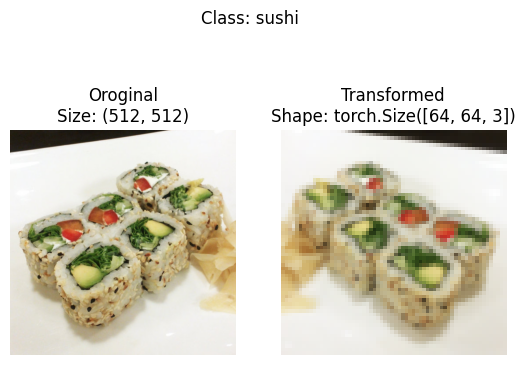

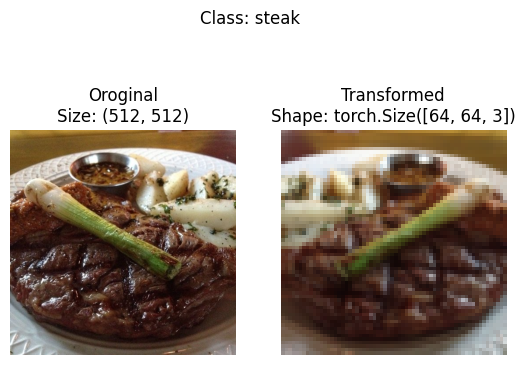

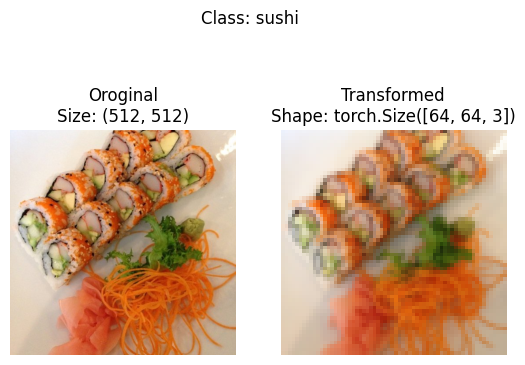

In [14]:

def plot_transformed_images(image_paths: list, transform: torchvision.transforms, n=3, seed=None):
    
    if seed:
        random.seed(seed)
    
    random_image_paths = random.sample(image_paths, k=n)
    
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            
            ax[0].imshow(f)
            ax[0].set_title(f"Oroginal\nSize: {f.size}")
            ax[0].axis(False)
            
            # transform and plot the image
            transformed_image = transform(f).permute(1, 2, 0)   # from [C, H, W] -> [H, W, C]
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
            ax[1].axis("off")
            
            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=12)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=None)

##### Option1: Loading image data using `ImageFolder`

In [15]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets

train_data = datasets.ImageFolder(
    root=train_dir,
    transform=data_transform,
    target_transform=None
)

test_data = datasets.ImageFolder(
    root=test_dir,
    transform=data_transform,
    target_transform=None
)

In [16]:
train_data

Dataset ImageFolder
    Number of datapoints: 225
    Root location: data\pizza_steak_sushi\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

In [17]:
test_data

Dataset ImageFolder
    Number of datapoints: 75
    Root location: data\pizza_steak_sushi\test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

In [20]:
# get the class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [21]:
# get the classes as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [22]:
len(train_data), len(test_data)

(225, 75)

In [23]:
train_data.samples[0]

('data\\pizza_steak_sushi\\train\\pizza\\1008844.jpg', 0)

In [25]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Shape of the image: {img.shape}")
print(f"Data type of the tensor: {img.dtype}")
print(f"Label of image: {label}")
print(f"Data type of the label: {type(label)}")

Image tensor:
tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

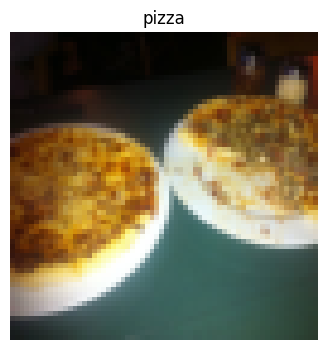

In [27]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0) # from [C, H, W] to [H, W, C]

# visualize the image
plt.figure(figsize=(6, 4))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=12)
plt.show()

#### Turn the `Dataset` into `DataLoader`'s
A `DataLoader` is going to help us to turn our `Dataset` into iterable. We can customize the `batch size`, so our model can see `batch size` images at a time.

In [28]:
import os
os.cpu_count()

12

In [81]:
# turn our train and test datasets into DataLoader's
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    num_workers=4,
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    num_workers=4,
    shuffle=False
)

train_dataloader, test_dataloader


(<torch.utils.data.dataloader.DataLoader at 0x18695b88fd0>,
 <torch.utils.data.dataloader.DataLoader at 0x1869432b250>)

In [82]:
len(train_dataloader), len(test_dataloader)

(8, 3)

In [83]:
images, labels = next(iter(train_dataloader))
images.shape # [batch_size, C, H, W]

torch.Size([32, 3, 64, 64])

In [84]:
type(labels)

torch.Tensor

In [85]:
labels.shape 

torch.Size([32])

In [74]:
# let's build a model

class FoodModel(nn.Module):
    
    def __init__(self, input_channels, output_shape, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_channels,
                kernel_size=3,
                stride=1,
                padding='same',
                out_channels=32
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=32,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding='same'
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2
            )
        )
        
        self.block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding='same'
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=64,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding='same'
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2
            )
        )
        
        self.block_3 = nn.Sequential(
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding='same'
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=128,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding='same'
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2
            )
        )
        
        self.fully_conn_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=128*8*8, out_features=4096),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(in_features=4096, out_features=512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(in_features=512, out_features=output_shape)
        )
    
    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.fully_conn_block(x)
        return x

In [75]:
model_1 = FoodModel(
    input_channels=3,
    output_shape=len(class_names)
).to(device)

In [76]:
from torchsummary import summary

summary(model_1, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             896
              ReLU-2           [-1, 32, 64, 64]               0
            Conv2d-3           [-1, 32, 64, 64]           9,248
              ReLU-4           [-1, 32, 64, 64]               0
         MaxPool2d-5           [-1, 32, 32, 32]               0
            Conv2d-6           [-1, 64, 32, 32]          18,496
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,928
              ReLU-9           [-1, 64, 32, 32]               0
        MaxPool2d-10           [-1, 64, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]          73,856
             ReLU-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 128, 16, 16]         147,584
             ReLU-14          [-1, 128,

In [77]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [78]:

def train_step(model: torch.nn.Module,
                data_loader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                optimizer: torch.optim.Optimizer,
                accuracy_fn,
                device: torch.device = device):
    
    train_loss, train_acc = 0, 0
    model.to(device)
    
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_logit = model(X)
        
        y_proba = torch.softmax(y_logit, dim=1)
        y_pred = y_proba.argmax(dim=1)

        # 2. Calculate loss
        loss = loss_fn(y_logit, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                y_pred=y_pred) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    
    

def test_step(data_loader: torch.utils.data.DataLoader,
                model: torch.nn.Module,
                loss_fn: torch.nn.Module,
                accuracy_fn,
                device: torch.device = device):
    
    test_loss, test_acc = 0, 0
    model.to(device)
    
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_logit = model(X)
            test_proba = torch.softmax(test_logit, dim=1)
            test_pred = test_proba.argmax(dim=1)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_logit, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred # Go from logits -> pred labels
            )
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [79]:
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    
    return total_time

In [86]:
from tqdm.auto import tqdm # type: ignore

# Measure time
from timeit import default_timer as timer
train_time_start_model_1 = timer()

model_1 = FoodModel(
    input_channels=3,
    output_shape=len(class_names)
).to(device)

# Train and test model 
epochs = 10

# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                        betas=(0.9, 0.999),
                        lr=0.001)

# optimizer = torch.optim.SGD(params=model_0.parameters(),
#                         lr=0.1)

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    
    train_step(data_loader=train_dataloader, 
        model=model_1, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    
    test_step(data_loader=test_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

train_time_end_model_1 = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_model_1,
                                        end=train_time_end_model_1,
                                        device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 1.11712 | Train accuracy: 27.73%
Test loss: 1.10433 | Test accuracy: 19.79%

Epoch: 1
---------
Train loss: 1.10036 | Train accuracy: 29.30%
Test loss: 1.10027 | Test accuracy: 19.79%

Epoch: 2
---------
Train loss: 1.09882 | Train accuracy: 37.89%
Test loss: 1.09349 | Test accuracy: 54.17%

Epoch: 3
---------
Train loss: 1.09597 | Train accuracy: 40.23%
Test loss: 1.08646 | Test accuracy: 54.17%

Epoch: 4
---------
Train loss: 1.10426 | Train accuracy: 28.12%
Test loss: 1.07859 | Test accuracy: 54.17%

Epoch: 5
---------
Train loss: 1.08282 | Train accuracy: 41.02%
Test loss: 1.07441 | Test accuracy: 26.04%

Epoch: 6
---------
Train loss: 1.08742 | Train accuracy: 32.81%
Test loss: 1.06956 | Test accuracy: 32.10%

Epoch: 7
---------
Train loss: 1.12310 | Train accuracy: 32.03%
Test loss: 1.03954 | Test accuracy: 35.04%

Epoch: 8
---------
Train loss: 1.07659 | Train accuracy: 34.38%
Test loss: 1.10227 | Test accuracy: 31.06%

Epoch: 9
---------
Train los